In [1]:
# Name of test to be plotted
test = 'Example1'
model = 'TwoBreakdownTypes'
mode = 'VP'
M = 11 # Grid size as an exponent of 2

name = test + '_' + model + '_' + mode + '_' + str(M)

save_to_file = True;

## Import Packages

In [2]:
## General purpose
import numpy as np
import os
import numpy.ma as ma
import string

## Plotting-specific
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import matplotlib.ticker as ticker

## Set plotting defaults
titletextsize = 18
labeltextsize = 14
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('savefig', dpi = 300)
n_levels = 15

figwidth  = 3
figheight = 3

## Define function for formatting colorbar in scientific notation
##      From here: https://stackoverflow.com/questions/25983218/scientific-notation-colorbar-in-matplotlib
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

## Define function for setting axis size
##      From here: https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
## Define output directory for saving figures to file
output_directory = name
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

## Compare to Analytic Ground Truth

### Read in Data

In [3]:
# General file reading information
fdtype = np.dtype('f8')
data_location = '../output/' + name
   
## Read in grid sizes
gridsizes = np.fromfile(data_location + '_GridSizes', 'int32')
nx = gridsizes[0]
ny = gridsizes[1]

## Read in step sizes
stepsizes = np.fromfile(data_location + '_StepSizes', fdtype)
dx = stepsizes[0]
dy = stepsizes[1]

## 1D domain
X = np.arange(0,nx)*dx
Y = np.arange(0,ny)*dy

## Read in domain
domain = np.fromfile(data_location + '_Domain',np.dtype('bool'))
domain = domain.reshape(nx,ny)
not_domain = 1-domain

## Read in depots
depots = np.fromfile(data_location + '_Depots',np.dtype('bool'))
depots = depots.reshape(nx,ny)

## Read in goal
goals = np.fromfile(data_location + '_Goal',np.dtype('bool'))
goals = goals.reshape(nx,ny)

X_grid, Y_grid = np.meshgrid(X,Y)
depots_y = X_grid[depots.transpose()]
depots_x = Y_grid[depots.transpose()]
goals_y = X_grid[goals.transpose()]
goals_x = Y_grid[goals.transpose()]

## Define function for reading variables from file
def read_from_file(suffix):
    temp = np.fromfile(data_location + suffix, fdtype)
    temp = temp.reshape(nx,ny)
    return ma.masked_array(temp, mask=not_domain)

## Read in arrays
K_1   = read_from_file('_WorkingRunningCost')
f_1   = read_from_file('_WorkingSpeed')
u_1   = read_from_file('_WorkingCost')

if model == 'TwoBreakdownTypes' or model == 'OnlyTotalBreakdowns':
    lambda_1 = read_from_file('_WorkingTotalBreakdownRate')
    K_r   = read_from_file('_RepairRunningCost')
    f_r   = read_from_file('_RepairSpeed')
    u_r   = read_from_file('_RepairCost')
    r = read_from_file('_FieldRepairCost')
if model == 'TwoBreakdownTypes' or model == 'OnlyPartialBreakdowns':
    u_2   = read_from_file('_DamagedCost')
    f_2   = read_from_file('_DamagedSpeed')
    K_2   = read_from_file('_DamagedRunningCost')
    phi = read_from_file('_WorkingPartialBreakdownRate')
    
    ## Read in summary data
    iterTypes = np.fromfile(data_location + '_IterationType', np.dtype('int'))
    iterProgress = np.fromfile(data_location + '_IterationProgress', fdtype)
if model == 'TwoBreakdownTypes':
    lambda_2 = read_from_file('_DamagedTotalBreakdownRate')


### Compute Analytic Solution

In [4]:
## Define worst parameters
f_1_hat = np.min(f_1)
f_2_hat = np.min(f_2)
f_r_hat = np.min(f_r)
K_1_hat = np.max(K_1-(lambda_1)*(r+u_r))
K_2_hat = np.max(K_2 - (lambda_2)*(r+u_r))
K_r_hat = np.max(K_r)
phi_hat = np.max(phi)
lambda_1_hat = np.max(lambda_1)
lambda_2_hat = np.max(lambda_2)
r_hat = np.max(r)
                      
R2 = 0
R3 = 0
L = 0.5

## Compute closed-form solutions
A = phi_hat/f_1_hat + lambda_2_hat/f_2_hat;
B = -1*(K_1_hat/f_1_hat - K_2_hat/f_2_hat) - (lambda_1_hat/f_1_hat - lambda_2_hat/f_2_hat)*(r_hat + R3 + K_r_hat*L/f_r_hat)
C = (lambda_1_hat/f_1_hat - lambda_2_hat/f_2_hat)*(K_r_hat/f_r_hat)

Q1 = phi_hat*(B/A + C*L/A + C/A**2 - R2)/(f_1_hat*A)
Q2 = -lambda_2_hat*(B/A + C*L/A + C/A**2 - R2)/(f_2_hat*A)
P1 = (1/2)*((lambda_1_hat * K_r_hat)/(f_1_hat*f_r_hat) - phi_hat*C/(f_1_hat*A))
P2 = (1/2)*((lambda_2_hat * K_r_hat)/(f_2_hat*f_r_hat) + lambda_2_hat*C/(f_2_hat*A))
N1 = -K_1_hat/f_1_hat - (lambda_1_hat/f_1_hat)*(r_hat+R3+K_r_hat*L/f_r_hat) - (phi_hat/f_1_hat)*(B/A + C/A**2)
N2 = -K_2_hat/f_2_hat - (lambda_2_hat/f_2_hat)*(r_hat+R3+K_r_hat*L/f_r_hat) + (lambda_2_hat/f_2_hat)*(B/A + C/A**2)
M1 = -N1*L - P1*L**2 - Q1
M2 = R2 - N2*L - P2*L**2 - Q2

u_1_ana = M1 + N1*X + P1*X**2 + Q1*np.exp(A*(X-L))
u_2_ana = M2 + N2*X + P2*X**2 + Q2*np.exp(A*(X-L))
u_r_ana = -(K_r_hat/f_r_hat)*(X-L) + R3

### Plot Value Functions

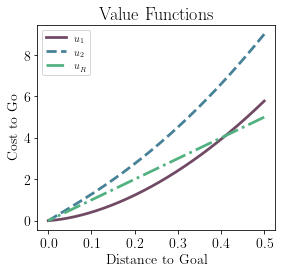

In [9]:
fig1, ax1 = plt.subplots()

colors = ['#704A64','#468197','#52B180']
linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
bound = 2**(M-1) + 1
R = 0.5 - X[1:bound]
plt.plot(R, u_1_ana[1:bound], colors[0], linestyle=linestyles[0], linewidth=2.75)
plt.plot(R, u_2_ana[1:bound], colors[1], linestyle=linestyles[1], linewidth=2.75)
plt.plot(R, u_r_ana[1:bound], colors[2], linestyle=linestyles[2], linewidth=2.75)

## Format figure
set_size(1.1*figwidth, 0.95*figheight, ax1)
ax1.set_title('Value Functions', fontsize=titletextsize)
ax1.set_xlabel('Distance to Goal', fontsize=labeltextsize)
ax1.set_ylabel('Cost to Go', fontsize=labeltextsize)
plt.setp(ax1.get_xticklabels(), fontsize=labeltextsize)
plt.setp(ax1.get_yticklabels(), fontsize=labeltextsize)
ax1.legend(['$u_1$', '$u_2$', '$u^{}_R$'])

plt.show()
if save_to_file:
    fig1.savefig(output_directory + '/' + name + '_ValueFunctions1D.png', bbox_inches='tight') 

### Plot Convergence

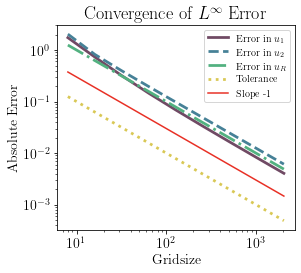

In [10]:
fig1, ax1 = plt.subplots()
Ms = range(3,12)

u_1_errors = np.zeros(np.shape(Ms))
u_2_errors = np.zeros(np.shape(Ms))
u_r_errors = np.zeros(np.shape(Ms))

for i in range(len(Ms)):
    M = Ms[i]
    bound = 2**(M-1) + 1
    name = test + '_' + model + '_' + mode + '_' + str(M)
    data_location = '../output/' + name

    ## Read in grid sizes
    gridsizes = np.fromfile(data_location + '_GridSizes', 'int32')
    nx = gridsizes[0]
    ny = gridsizes[1]

    ## Read in step sizes
    stepsizes = np.fromfile(data_location + '_StepSizes', fdtype)
    dx = stepsizes[0]
    dy = stepsizes[1]

    ## 1D domain
    X = np.arange(0,nx)*dx
    Y = np.arange(0,ny)*dy

    ## Read in domain
    domain = np.fromfile(data_location + '_Domain',np.dtype('bool'))
    domain = domain.reshape(nx,ny)
    not_domain = 1-domain

    ## Read in arrays
    u_1 = read_from_file('_WorkingCost')
    u_2 = read_from_file('_DamagedCost')
    u_r = read_from_file('_RepairCost')
    
    u_1_ana = M1 + N1*X + P1*X**2 + Q1*np.exp(A*(X-L));
    u_2_ana = M2 + N2*X + P2*X**2 + Q2*np.exp(A*(X-L));
    u_r_ana = -(K_r_hat/f_r_hat)*(X-L) + R3;
    
    u_1_errors[i] = np.max(abs(u_1[bound,1:bound] - u_1_ana[1:bound]))
    u_2_errors[i] = np.max(abs(u_2[bound,1:bound] - u_2_ana[1:bound]))
    u_r_errors[i] = np.max(abs(u_r[bound,1:bound] - u_r_ana[1:bound]))
    
colors = ['#704A64','#468197','#52B180','#D9C855', '#E83025']
linestyles = ['solid', 'dashed', 'dashdot', 'dotted', 'solid']
ind = np.array([2**M for M in Ms])
plt.loglog(ind, u_1_errors, colors[0], linestyle=linestyles[0], linewidth=2.75)
plt.loglog(ind, u_2_errors, colors[1], linestyle=linestyles[1], linewidth=2.75)
plt.loglog(ind, u_r_errors, colors[2], linestyle=linestyles[2], linewidth=2.75)
plt.loglog(ind, 1/ind, colors[3], linestyle=linestyles[3], linewidth=2.75)
plt.loglog(ind, 3/ind, colors[4], linestyle=linestyles[4], linewidth=1.5)

## Format figure
set_size(1.1*figwidth, 0.95*figheight, ax1)
ax1.set_title('Convergence of $L^\infty$ Error', fontsize=titletextsize)
ax1.set_xlabel('Gridsize', fontsize=labeltextsize)
ax1.set_ylabel('Absolute Error', fontsize=labeltextsize)
plt.setp(ax1.get_xticklabels(), fontsize=labeltextsize)
plt.setp(ax1.get_yticklabels(), fontsize=labeltextsize)
ax1.legend(['Error in $u_1$', 'Error in $u_2$', 'Error in $u_R$', 'Tolerance', 'Slope -1'])

plt.show()
if save_to_file:
    fig1.savefig(output_directory + '/' + name + '_ErrorConvergence.png', bbox_inches='tight')    

### Plot Errors

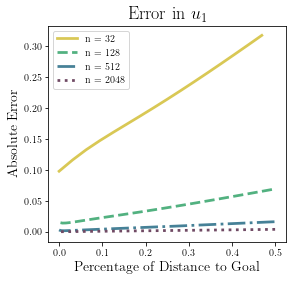

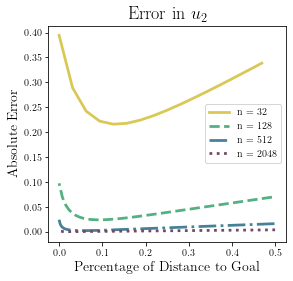

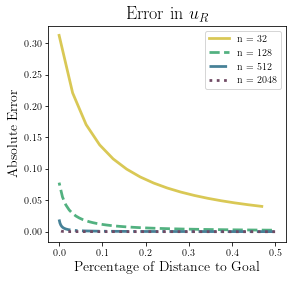

In [50]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

colors = ['#D9C855','#52B180','#468197','#704A64']
linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
Ms = [5, 7, 9, 11]

for i in range(len(Ms)):
    M = Ms[i]
    bound = 2**(M-1) + 1
    name = test + '_' + model + '_' + mode + '_' + str(M)
    data_location = '../output/' + name
    
    ## Read in grid sizes
    gridsizes = np.fromfile(data_location + '_GridSizes', 'int32')
    nx = gridsizes[0]
    ny = gridsizes[1]

    ## Read in step sizes
    stepsizes = np.fromfile(data_location + '_StepSizes', fdtype)
    dx = stepsizes[0]
    dy = stepsizes[1]

    ## 1D domain
    X = np.arange(0,nx)*dx
    Y = np.arange(0,ny)*dy

    ## Read in domain
    domain = np.fromfile(data_location + '_Domain',np.dtype('bool'))
    domain = domain.reshape(nx,ny)
    not_domain = 1-domain

    ## Read in arrays
    u_1 = read_from_file('_WorkingCost')
    u_2 = read_from_file('_DamagedCost')
    u_r = read_from_file('_RepairCost')
    
    u_1_ana = M1 + N1*X + P1*X**2 + Q1*np.exp(A*(X-L));
    u_2_ana = M2 + N2*X + P2*X**2 + Q2*np.exp(A*(X-L));
    u_r_ana = -(K_r_hat/f_r_hat)*(X-L) + R3;
    
    d = (0.5 - X[1:bound])
    ax1.plot(d, abs(u_1 - u_1_ana)[bound,1:bound], color=colors[i], linestyle=linestyles[i], linewidth=2.75)
    ax2.plot(d, abs(u_2 - u_2_ana)[bound,1:bound], color=colors[i], linestyle=linestyles[i], linewidth=2.75)
    ax3.plot(d, abs(u_r - u_r_ana)[bound,1:bound], color=colors[i], linestyle=linestyles[i], linewidth=2.75)

## Format figures
titles = ['Error in $u_1$', 'Error in $u_2$', 'Error in $u_R$']
axs = [ax1, ax2, ax3]
for i in range(3):
    ax = axs[i]
    set_size(1.1*figwidth, figheight, ax)
    ax.set_title(titles[i], fontsize=titletextsize)
    ax.set_xlabel('Percentage of Distance to Goal', fontsize=labeltextsize)
    ax.set_ylabel('Absolute Error', fontsize=labeltextsize)
    plt.setp(ax.get_xticklabels(), fontsize=labeltextsize)
    plt.setp(ax.get_yticklabels(), fontsize=labeltextsize)
    ax.legend(['n = 32', 'n = 128', 'n = 512', 'n = 2048'])

plt.show()
if save_to_file:
    fig1.savefig(output_directory + '/' + name + '_WorkingError.png', bbox_inches='tight')    
    fig2.savefig(output_directory + '/' + name + '_DamagedError.png', bbox_inches='tight')    
    fig3.savefig(output_directory + '/' + name + '_RepairError.png', bbox_inches='tight')